In [1]:
import math
import os
import random
import torch
from d2l import torch as d2l

In [2]:
d2l.DATA_HUB['ptb'] = (d2l.DATA_URL + 'ptb.zip',
                       '319d85e578af0cdc590547f26231e4e31cdf1e42')

def read_ptb():
    '''将 PTB 数据集加载到文本行的列表中'''
    data_dir = d2l.download_extract('ptb')
    with open(os.path.join(data_dir, 'ptb.train.txt')) as f:
        raw_text = f.read()
    return [line.split() for line in raw_text.split('\n')]

sentences = read_ptb()
f'# sentences 数：{len(sentences)}'

'# sentences 数：42069'

In [3]:
vocab = d2l.Vocab(sentences, min_freq=10)
f'vocab size: {len(vocab)}'

'vocab size: 6719'

In [4]:
def subsample(sentences, vocab):
    '''下采样高频词'''
    # 排除未知词元 <unk>
    sentences = [[token for token in line if vocab[token] != vocab.unk]
                 for line in sentences]
    counter = d2l.count_corpus(sentences)
    num_tokens = sum(counter.values()) # 总词数
    
    # 如果在下采样期间保留词元，则返回 True
    def keep(token):
        return (random.uniform(0, 1) <
                math.sqrt(1e-4 / counter[token] * num_tokens))
    
    return ([[token for token in line if keep(token)] for line in sentences], 
            counter)

subsampled, counter = subsample(sentences, vocab)

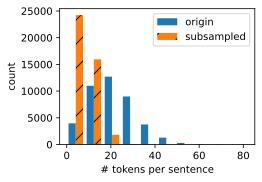

In [5]:
d2l.show_list_len_pair_hist(
    ['origin', 'subsampled'], '# tokens per sentence',
    'count', sentences, subsampled)

In [6]:
def compare_counts(token):
    return (f'"{token}"的数量：'
            f'之前={sum([l.count(token) for l in sentences])}, '
            f'之后={sum([l.count(token) for l in subsampled])}')

compare_counts('the')

'"the"的数量：之前=50770, 之后=2049'

In [7]:
compare_counts('join')

'"join"的数量：之前=45, 之后=45'

In [8]:
corpus = [vocab[line] for line in subsampled]
corpus[: 3]

[[], [392, 2115, 1, 406], [22, 140, 5277, 3054, 1580]]

In [9]:
def get_centers_and_contexts(corpus, max_window_size):
    '''返回跳元模型中的中心词和上下文词'''
    centers, contexts = [], []
    for line in corpus:
        # 要形成 中心词-上下文词对，每个句子至少需要有两个词
        if len(line) < 2:
            continue
        centers += line
        for i in range(len(line)): # 上下文窗口中间 i
            window_size = random.randint(1, max_window_size)
            indices = list(range(max(0, i - window_size),
                                 min(len(line), i + 1 + window_size)))
            # 从上下文词中排除中心词
            indices.remove(i)
            contexts.append([line[idx] for idx in indices])
    return centers, contexts

In [10]:
tiny_dataset = [list(range(7)), list(range(5, 10))]
print('数据集', tiny_dataset)
for center, context in zip(*get_centers_and_contexts(tiny_dataset, 2)):
    print('中心词', center, '的上下文词是', context)

数据集 [[0, 1, 2, 3, 4, 5, 6], [5, 6, 7, 8, 9]]
中心词 0 的上下文词是 [1]
中心词 1 的上下文词是 [0, 2, 3]
中心词 2 的上下文词是 [1, 3]
中心词 3 的上下文词是 [2, 4]
中心词 4 的上下文词是 [3, 5]
中心词 5 的上下文词是 [4, 6]
中心词 6 的上下文词是 [5]
中心词 5 的上下文词是 [6, 7]
中心词 6 的上下文词是 [5, 7, 8]
中心词 7 的上下文词是 [5, 6, 8, 9]
中心词 8 的上下文词是 [7, 9]
中心词 9 的上下文词是 [7, 8]


In [11]:
all_centers, all_contexts = get_centers_and_contexts(corpus, 5)
f'# "中心词-上下文词对"的数量：{sum([len(contexts) for contexts in all_contexts])}'

'# "中心词-上下文词对"的数量：1498219'

In [12]:
class RandomGenerator:
    '''根据 n 个采样权重在 {1, ..., n} 中随机抽取'''
    def __init__(self, sampling_weights):
        self.population = list(range(1, len(sampling_weights) + 1))
        self.sampling_weights = sampling_weights
        self.candidates = []
        self.i = 0
        
    def draw(self):
        if self.i == len(self.candidates):
            # 缓存 k 个随机采样结果
            self.candidates = random.choices(
                self.population, self.sampling_weights, k=10000)
            self.i = 0
        self.i += 1
        # 当 i < k 时，直接用之前存储的结果，不用重新抽
        return self.candidates[self.i - 1]

In [13]:
generator = RandomGenerator([2, 3, 4])
[generator.draw() for _ in range(10)]

[2, 3, 2, 2, 2, 3, 2, 2, 3, 3]

In [14]:
def get_negatives(all_contexts, vocab, counter, K):
    '''返回负采样中的噪声词'''
    # 索引为 1、2、...（索引 0 是词表中排除的 <unk>）
    # 得到相对频率
    sampling_weights = [counter[vocab.to_tokens(i)] ** 0.75
                        for i in range(1, len(vocab))]
    all_negatives, generator = [], RandomGenerator(sampling_weights)
    for contexts in all_contexts:
        negatives = []
        # 每一个正例对应 K 个负例
        while len(negatives) < len(contexts) * K:
            neg = generator.draw()
            # 噪声词不能是上下文词
            if neg not in contexts:
                negatives.append(neg)
        all_negatives.append(negatives)
    return all_negatives

all_negatives = get_negatives(all_contexts, vocab, counter, 5)

In [15]:
def batchify(data):
    '''返回带有负采样的跳元模型的小批量样本'''
    # data: [(中心词 center, 上下文词 context, 噪声词 negative)] 长度为批量大小
    max_len = max(len(c) + len(n) for _, c, n in data) 
    # 最长的一组上下文词 + 噪声词 列表
    centers, contexts_negatives, masks, labels = [], [], [], []
    for center, context, negative in data:
        cur_len = len(context) + len(negative)
        centers += [center]
        contexts_negatives += \
            [context + negative + [0] * (max_len - cur_len)]
        masks += [[1] * cur_len + [0] * (max_len - cur_len)]
        labels += [[1] * len(context) + [0] * (max_len - len(context))]
    return (torch.tensor(centers).reshape((-1, 1)), torch.tensor(
        contexts_negatives), torch.tensor(masks), torch.tensor(labels))

In [16]:
x_1 = (1, [2, 2], [3, 3, 3, 3])
x_2 = (1, [2, 2, 2], [3, 3])
batch = batchify((x_1, x_2))

names = ['centers', 'contexts_negatives', 'masks', 'labels']
for name, data in zip(names, batch):
    print(name, '=', data)

centers = tensor([[1],
        [1]])
contexts_negatives = tensor([[2, 2, 3, 3, 3, 3],
        [2, 2, 2, 3, 3, 0]])
masks = tensor([[1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0]])
labels = tensor([[1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0]])


In [17]:
def load_data_ptb(batch_size, max_window_size, num_noise_words):
    '''下载 ptb 数据集，然后将其加载到内存中'''
    num_workers = d2l.get_dataloader_workers()
    sentences = read_ptb()
    vocab = d2l.Vocab(sentences, min_freq=10)
    subsampled, counter = subsample(sentences, vocab)
    corpus = [vocab[line] for line in subsampled]
    all_centers, all_contexts = get_centers_and_contexts(
        corpus, max_window_size)
    all_negatives = get_negatives(
        all_contexts, vocab, counter, num_noise_words)
    
    class PTBDataset(torch.utils.data.Dataset):
        def __init__(self, centers, contexts, negatives):
            assert len(centers) == len(contexts) == len(negatives)
            self.centers = centers
            self.contexts = contexts
            self.negatives = negatives
        
        def __getitem__(self, index):
            return (self.centers[index], self.contexts[index],
                    self.negatives[index])
        
        def __len__(self):
            return len(self.centers)
        
    dataset = PTBDataset(all_centers, all_contexts, all_negatives)
    
    # collate_fn 允许对抽取出来的 batch 作进一步处理
    '''
    indices = next(self.sample_iter)
    batch = self.collate_fn([dataset[i] for i in indices])
    '''
    data_iter = torch.utils.data.DataLoader(
        dataset, batch_size, shuffle=True,
        collate_fn=batchify, num_workers=num_workers)
    return data_iter, vocab

In [18]:
data_iter, vocab = load_data_ptb(512, 5, 5)
for batch in data_iter:
    for name, data in zip(names, batch):
        print(name, 'shape:', data.shape)
    break

centers shape: torch.Size([512, 1])
contexts_negatives shape: torch.Size([512, 60])
masks shape: torch.Size([512, 60])
labels shape: torch.Size([512, 60])


In [19]:
from torch import nn

batch_size, max_window_size, num_noise_words = 512, 5, 5
data_iter, vocab = load_data_ptb(batch_size, max_window_size,
                                 num_noise_words)

In [20]:
embed = nn.Embedding(num_embeddings=20, embedding_dim=4)
print(f'Parameter embedding_weight ({embed.weight.shape}, '
      f'dtype={embed.weight.dtype})')

Parameter embedding_weight (torch.Size([20, 4]), dtype=torch.float32)


In [21]:
x = torch.tensor([[1, 2, 3], [4, 5, 6]])
# (2, 3) => (2, 3, 4)
embed(x)

tensor([[[-1.8432, -0.0949, -1.5580,  1.4188],
         [ 1.3605,  0.3122, -0.7549, -0.6117],
         [ 0.4828, -2.8884, -1.1345,  1.4906]],

        [[-0.0057,  0.3927, -0.3562,  1.0143],
         [ 0.1134, -0.5929,  0.1465, -1.7607],
         [ 1.1727, -1.1046, -0.3137,  0.3003]]], grad_fn=<EmbeddingBackward0>)

In [22]:
def skip_gram(center, contexts_and_negatives, embed_v, embed_u):
    v = embed_v(center) # (batch_size, 1, embed_size)
    u = embed_u(contexts_and_negatives) # (batch_size, max_len, embed_size)
    pred = torch.bmm(v, u.permute(0, 2, 1)) # (batch_size, 1, max_len)
    # 输出的每个元素是中心词向量和上下文或噪声词向量的点积
    return pred

In [23]:
skip_gram(torch.ones((2, 1), dtype=torch.long),
          torch.ones((2, 4), dtype=torch.long), embed, embed).shape

torch.Size([2, 1, 4])

In [24]:
class SigmoidBCELoss(nn.Module):
    # 带掩码的二元交叉熵损失
    def __init__(self):
        super().__init__()
        
    def forward(self, inputs, target, mask=None):
        out = nn.functional.binary_cross_entropy_with_logits(
            inputs, target, weight=mask, reduction='none')
        return out.mean(dim=1)
    
loss = SigmoidBCELoss()

In [25]:
pred = torch.tensor([[1.1, -2.2, 3.3, -4.4]] * 2)
label = torch.tensor([[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0]])
mask = torch.tensor([[1, 1, 1, 1], [1, 1, 0, 0]])
# 需要进行缩放，因为 Loss 中求平均默认是 除以 mask.shape[1]
# 但对应 mask[1] 中应该除以 2 而不是除以 4
loss(pred, label, mask) * mask.shape[1] / mask.sum(axis=1)

tensor([0.9352, 1.8462])

In [26]:
def sigmd(x):
    return -math.log(1 / (1 + math.exp(-x)))

print(f'{(sigmd(1.1) + sigmd(2.2) + sigmd(-3.3) + sigmd(4.4)) / 4:.4f}')
print(f'{(sigmd(-1.1) + sigmd(-2.2)) / 2:.4f}')

0.9352
1.8462


In [27]:
embed_size = 100
net = nn.Sequential(nn.Embedding(num_embeddings=len(vocab),
                                 embedding_dim=embed_size),
                    nn.Embedding(num_embeddings=len(vocab),
                                 embedding_dim=embed_size))

In [28]:
def train(net, data_iter, lr, num_epochs, device=d2l.try_gpu()):
    def init_weights(m):
        if type(m) == nn.Embedding:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    net = net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs])
    # 规范化的损失之和，规范化的损失数
    metric = d2l.Accumulator(2)
    for epoch in range(num_epochs):
        timer, num_batches = d2l.Timer(), len(data_iter)
        for i, batch in enumerate(data_iter):
            optimizer.zero_grad()
            center, context_negative, mask, label = [
                data.to(device) for data in batch]
            pred = skip_gram(center, context_negative, net[0], net[1])
            # pred: (batch_size, 1, max_len) => (batch_size, max_len)
            l = (loss(pred.reshape(label.shape).float(), label.float(), mask)
                 / mask.sum(axis=1) * mask.shape[1])
            l.sum().backward()
            optimizer.step()
            metric.add(l.sum(), l.numel())
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches, 
                             (metric[0] / metric[1], ))
    print(f'loss {metric[0] / metric[1]:.3f}, '
          f'{metric[1] / timer.stop():.1f} tokens/sec on {str(device)}')

loss 0.410, 130422.5 tokens/sec on cpu


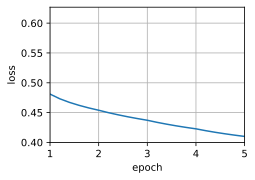

In [29]:
lr, num_epochs = 0.002, 5
train(net, data_iter, lr, num_epochs)

In [30]:
def get_similar_tokens(query_token, k, embed):
    W = embed.weight.data # (vocab_size, embed)
    x = W[vocab[query_token]] # (embed)
    # 计算余弦相似性，增加 1e-9 以获得数值稳定性
    # torch.mv: 矩阵乘以向量
    # .mv => (vocab_size, 1) 与每个词元的 embedding 点乘后除以 模的乘积
    cos = torch.mv(W, x) / torch.sqrt(torch.sum(W * W, dim=1) *
                                      torch.sum(x * x) + 1e-9)
    topk = torch.topk(cos, k=k+1)[1].cpu().numpy().astype('int32')
    # topk()[0]: values, topk()[1]: indices
    for i in topk[1:]: # 删除输入词（第一个）
        print(f'cosine sim={float(cos[i]):.3f}: {vocab.to_tokens(i)}')

get_similar_tokens('chip', 3, net[0]) # 选择中心词向量，net[1] 是上下文词向量

cosine sim=0.677: intel
cosine sim=0.665: microprocessor
cosine sim=0.639: motorola


In [31]:
import collections

symbols = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
           'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z',
           '_', '[UNK]']

In [32]:
# 词: 频率
raw_token_freqs = {'fast_': 4, 'faster_': 3, 'tall_': 5, 'taller_': 4}
token_freqs = {}
for token, freq in raw_token_freqs.items():
    token_freqs[' '.join(list(token))] = raw_token_freqs[token]
token_freqs

{'f a s t _': 4, 'f a s t e r _': 3, 't a l l _': 5, 't a l l e r _': 4}

In [33]:
def get_max_freq_pair(token_freqs):
    pairs = collections.defaultdict(int)
    for token, freq in token_freqs.items():
        symbols = token.split()
        for i in range(len(symbols) - 1):
            # pairs 的键是两个连续符号的元组
            pairs[symbols[i], symbols[i + 1]] += freq
    
    return max(pairs, key=pairs.get) # 具有最大值的 pairs 键

In [34]:
get_max_freq_pair(token_freqs)

('t', 'a')

In [35]:
def merge_symbols(max_freq_pair, token_freqs, symbols):
    symbols.append(''.join(max_freq_pair))
    new_token_freqs = dict()
    for token, freq in token_freqs.items():
        # 例如，最频繁字节对为 ta
        # 则将 token 中的 t a 替换为 ta
        new_token = token.replace(' '.join(max_freq_pair),
                                  ''.join(max_freq_pair))
        new_token_freqs[new_token] = token_freqs[token]
    return new_token_freqs

In [36]:
num_merges = 10
for i in range(num_merges):
    max_freq_pair = get_max_freq_pair(token_freqs)
    token_freqs = merge_symbols(max_freq_pair, token_freqs, symbols)
    print(f'合并# {i+1}:', max_freq_pair)

合并# 1: ('t', 'a')
合并# 2: ('ta', 'l')
合并# 3: ('tal', 'l')
合并# 4: ('f', 'a')
合并# 5: ('fa', 's')
合并# 6: ('fas', 't')
合并# 7: ('e', 'r')
合并# 8: ('er', '_')
合并# 9: ('tall', '_')
合并# 10: ('fast', '_')


In [37]:
print(symbols)

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '_', '[UNK]', 'ta', 'tal', 'tall', 'fa', 'fas', 'fast', 'er', 'er_', 'tall_', 'fast_']


In [38]:
print(list(token_freqs.keys()))

['fast_', 'fast er_', 'tall_', 'tall er_']


In [39]:
def segment_BPE(tokens, symbols):
    outputs = []
    for token in tokens:
        # 从开头开始找最长的子词
        start, end = 0, len(token)
        cur_output = []
        while start < len(token):
            # 如果 start == end 了，即 token[start] 这个字符都不在词表中
            # 说明遇到了未知词元
            if start == end:
                cur_output.append('[UNK]')
                start += 1
                end = len(token)
                continue
            
            if token[start: end] in symbols:
                cur_output.append(token[start: end])
                # 找到了就将开头移到 end 后一位
                # 并且重置下一次寻找，继续从最长的开始找（即将 end 置尾）
                start = end
                end = len(token) 
            else:
                # 没找到就找次长的子词
                end -= 1
        outputs.append(' '.join(cur_output))
    return outputs

In [40]:
tokens = ['tallest_', 'fatter_', 'faAtAter_']
print(segment_BPE(tokens, symbols))

['tall e s t _', 'fa t t er_', 'fa [UNK] t [UNK] t er_']


In [41]:
d2l.DATA_HUB['glove.6b.50d'] = (d2l.DATA_URL + 'glove.6B.50d.zip',
                                '0b8703943ccdb6eb788e6f091b8946e82231bc4d')

d2l.DATA_HUB['glove.6b.100d'] = (d2l.DATA_URL + 'glove.6B.100d.zip',
                                 'cd43bfb07e44e6f27cbcc7bc9ae3d80284fdaf5a')

d2l.DATA_HUB['glove.42b.300d'] = (d2l.DATA_URL + 'glove.42B.300d.zip',
                                  'b5116e234e9eb9076672cfeabf5469f3eec904fa')

d2l.DATA_HUB['wiki.en'] = (d2l.DATA_URL + 'wiki.en.zip',
                           'c1816da3821ae9f43899be655002f6c723e91b88')

In [42]:
class TokenEmbedding:
    '''GloVe 嵌入'''
    def __init__(self, embedding_name):
        self.idx_to_token, self.idx_to_vec = self._load_embedding(
            embedding_name)
        self.unknown_idx = 0
        self.token_to_idx = {token: idx for idx, token in
                             enumerate(self.idx_to_token)}
        
    def _load_embedding(self, embedding_name):
        idx_to_token, idx_to_vec = ['<unk>'], []
        data_dir = d2l.download_extract(embedding_name)
        # GloVe网站：https://nlp.stanford.edu/projects/glove/
        # fastText网站：https://fasttext.cc/
        with open(os.path.join(data_dir, 'vec.txt'), 'r', 
                  encoding='utf-8') as f:
            for line in f:
                # .rstrip() 删除末尾的空白符
                elems = line.rstrip().split(' ')
                token, elems = elems[0], [float(elem) for elem in elems[1:]]
                # 跳过标题信息，例如 fastText 中的首行
                if len(elems) > 1:
                    idx_to_token.append(token)
                    idx_to_vec.append(elems)
            # 把 <unk> 向量表示为 [0, 0, ..., 0]
            idx_to_vec = [[0] * len(idx_to_vec[0])] + idx_to_vec
        return idx_to_token, torch.tensor(idx_to_vec)
    
    def __getitem__(self, tokens):
        # 传入的 tokens 必须是一个列表
        # 如果传入字符串，会将字符串分解为一个个字符
        indices = [self.token_to_idx.get(token, self.unknown_idx)
                   for token in tokens]
        vecs = self.idx_to_vec[torch.tensor(indices)]
        return vecs
    
    def __len__(self):
        return len(self.idx_to_token)

In [43]:
glove_6b50d = TokenEmbedding('glove.6b.50d')

In [44]:
len(glove_6b50d)

400001

In [45]:
glove_6b50d.token_to_idx['beautiful'], glove_6b50d.idx_to_token[3367]

(3367, 'beautiful')

In [46]:
def knn(W, x, k):
    # 增加 1e-9 以获得数值稳定性
    # 先把 x: (1, embed_size) => (embed_size)
    cos = torch.mv(W, x.reshape(-1,)) / (
        torch.sqrt(torch.sum(W * W, axis=1) + 1e-9) *
        torch.sqrt((x * x).sum()))
    _, topk = torch.topk(cos, k=k) # topk 中是索引
    return topk, [cos[int(i)] for i in topk]

In [47]:
def get_similar_tokens(query_token, k, embed):
    topk, cos = knn(embed.idx_to_vec, embed[[query_token]], k + 1)
    for i, c in zip(topk[1:], cos[1:]): # 排除自己（top1）
        print(f'{embed.idx_to_token[int(i)]}: cosine 相似度 = {float(c):.3f}')

In [48]:
get_similar_tokens('chip', 3, glove_6b50d)

chips: cosine 相似度 = 0.856
intel: cosine 相似度 = 0.749
electronics: cosine 相似度 = 0.749


In [49]:
glove_6b50d[['chip']].shape, glove_6b50d['chip'].shape

(torch.Size([1, 50]), torch.Size([4, 50]))

In [50]:
get_similar_tokens('baby', 3, glove_6b50d)

babies: cosine 相似度 = 0.839
boy: cosine 相似度 = 0.800
girl: cosine 相似度 = 0.792


In [51]:
get_similar_tokens('beautiful', 3, glove_6b50d)

lovely: cosine 相似度 = 0.921
gorgeous: cosine 相似度 = 0.893
wonderful: cosine 相似度 = 0.830


In [52]:
def get_analogy(token_a, token_b, token_c, embed):
    vecs = embed[[token_a, token_b, token_c]]
    x = vecs[1] - vecs[0] + vecs[2]
    topk, cos = knn(embed.idx_to_vec, x, 1)
    return embed.idx_to_token[int(topk[0])]

In [53]:
get_analogy('man', 'woman', 'son', glove_6b50d)

'daughter'

In [54]:
get_analogy('beijing', 'china', 'tokyo', glove_6b50d)

'japan'

In [55]:
get_analogy('bad', 'worst', 'big', glove_6b50d)

'biggest'

In [56]:
get_analogy('do', 'did', 'go', glove_6b50d)

'went'

In [57]:
glove_6b50d[['<unk>']].shape

torch.Size([1, 50])

In [58]:
def get_tokens_and_segments(tokens_a, tokens_b=None):
    '''获取输入序列的词元及其片段索引'''
    tokens = ['<cls>'] + tokens_a + ['<sep>']
    # 0 和 1 分别标记片段 A 和 B
    segments = [0] * (len(tokens_a) + 2)
    if tokens_b is not None:
        tokens += tokens_b + ['<sep>']
        segments += [1] * (len(tokens_b) + 1)
    return tokens, segments

In [59]:
class BERTEncoder(nn.Module):
    '''BERT 编码器'''
    def __init__(self, vocab_size, num_hiddens, norm_shape, ffn_num_input, 
                 ffn_num_hiddens, num_heads, num_layers, dropout,
                 max_len=1000, key_size=768, query_size=768, value_size=768, 
                 **kwargs):
        super(BERTEncoder, self).__init__(**kwargs)
        # 词元嵌入
        self.token_embedding = nn.Embedding(vocab_size, num_hiddens)
        # 片段嵌入
        self.segment_embedding = nn.Embedding(2, num_hiddens)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module(f"{i}", d2l.EncoderBlock(
                key_size, query_size, value_size, num_hiddens, norm_shape,
                ffn_num_input, ffn_num_hiddens, num_heads, dropout, True))
        # 在 BERT 中，位置嵌入是可学习的，因此我们创建一个足够长的位置嵌入参数
        self.pos_embedding = nn.Parameter(torch.randn(1, max_len,
                                                      num_hiddens))
        
    def forward(self, tokens, segments, valid_lens):
        # X: (batch_size, 最大序列长度, num_hiddens)
        X = self.token_embedding(tokens) + self.segment_embedding(segments)
        X = X + self.pos_embedding.data[:, :X.shape[1], :]
        for blk in self.blks:
            X = blk(X, valid_lens)
        return X

In [60]:
vocab_size, num_hiddens, ffn_num_hiddens, num_heads = 10000, 768, 1024, 4
norm_shape, ffn_num_input, num_layers, dropout = [768], 768, 2, 0.2
encoder = BERTEncoder(vocab_size, num_hiddens, norm_shape, ffn_num_input,
                      ffn_num_hiddens, num_heads, num_layers, dropout)

In [61]:
tokens = torch.randint(0, vocab_size, (2, 8))
segments = torch.tensor([[0, 0, 0, 0, 1, 1, 1, 1], [0, 0, 0, 1, 1, 1, 1, 1]])
encoded_X = encoder(tokens, segments, None)
encoded_X.shape

torch.Size([2, 8, 768])

In [62]:
class MaskLM(nn.Module):
    '''BERT 的掩蔽语言模型任务'''
    def __init__(self, vocab_size, num_hiddens, num_inputs=768, **kwargs):
        super(MaskLM, self).__init__(**kwargs)
        self.mlp = nn.Sequential(nn.Linear(num_inputs, num_hiddens),
                                 nn.ReLU(),
                                 nn.LayerNorm(num_hiddens),
                                 nn.Linear(num_hiddens, vocab_size))
        
    def forward(self, X, pred_positions):
        # X: (batch_size, 序列长度, num_inputs)
        num_pred_positions = pred_positions.shape[1]
        pred_positions = pred_positions.reshape(-1) # 展平
        # 为了之后 X[batch_idx, pred_positions] 一步到位
        batch_size = X.shape[0]
        batch_idx = torch.arange(0, batch_size)
        # 假设 batch_size=2, num_pred_positions=3
        # 那么 batch_idx = np.array([0, 0, 0, 1, 1, 1])
        batch_idx = torch.repeat_interleave(batch_idx, num_pred_positions)
        masked_X = X[batch_idx, pred_positions]
        # masked_X: (batch_size, num_pred_positions, num_inputs)
        masked_X = masked_X.reshape((batch_size, num_pred_positions, -1))
        mlm_Y_hat = self.mlp(masked_X)
        # mlm_Y_hat: (batch_size, num_pred_positions, vocab_size)
        return mlm_Y_hat

In [63]:
mlm = MaskLM(vocab_size, num_hiddens)
mlm_positions = torch.tensor([[1, 5, 2], [6, 1, 5]])
mlm_Y_hat = mlm(encoded_X, mlm_positions)
mlm_Y_hat.shape

torch.Size([2, 3, 10000])

In [64]:
mlm_Y = torch.tensor([[7, 6, 8], [10, 20, 30]])
loss = nn.CrossEntropyLoss(reduction='none')
mlm_l = loss(mlm_Y_hat.reshape((-1, vocab_size)), mlm_Y.reshape(-1))
mlm_l.shape

torch.Size([6])

In [65]:
# 这里仅仅是多层感知机的分类层，隐藏层定义在 BERTModel 中
class NextSentencePred(nn.Module):
    '''BERT 的下一句预测任务'''
    def __init__(self, num_inputs, **kwargs):
        super(NextSentencePred, self).__init__(**kwargs)
        self.output = nn.Linear(num_inputs, 2)
    
    def forward(self, X):
        return self.output(X)

In [66]:
#encoded_X = torch.flatten(encoded_X, start_dim=1)
# NSP 的输入: (batch_size, 序列长度 * num_hiddens)
nsp = NextSentencePred(encoded_X.shape[-1])
nsp_Y_hat = nsp(encoded_X[:, 0, :])
nsp_Y_hat.shape

torch.Size([2, 2])

In [67]:
nsp_y = torch.tensor([0, 1])
nsp_l = loss(nsp_Y_hat, nsp_y)
nsp_l.shape

torch.Size([2])

In [68]:
class BERTModel(nn.Module):
    '''BERT 模型'''
    def __init__(self, vocab_size, num_hiddens, norm_shape, ffn_num_input,
                 ffn_num_hiddens, num_heads, num_layers, dropout,
                 max_ken=1000, key_size=768, query_size=768, value_size=768,
                 hid_in_features=768, mlm_in_features=768,
                 nsp_in_features=768):
        super(BERTModel, self).__init__()
        self.encoder = BERTEncoder(vocab_size, num_hiddens, norm_shape,
                                   ffn_num_input, ffn_num_hiddens, num_heads,
                                   num_layers, dropout, max_len=max_len,
                                   key_size=key_size, query_size=query_size,
                                   value_size=value_size)
        self.hidden = nn.Sequential(nn.Linear(hid_in_features, num_hiddens),
                                    nn.Tanh())
        self.nsp = NextSentencePred(nsp_in_features) # (num_hiddens) 对应 self.hidden 的输出维度
        self.mlm = MaskLM(vocab_size, num_hiddens, mlm_in_features)
        
    def forward(self, tokens, segments, valid_lens=None,
                pred_positions=None):
        encoded_X = self.encoder(tokens, segments, valid_lens)
        if pred_positions is not None:
            mlm_Y_hat = self.mlm(encoded_X, pred_positions)
        else:
            mlm_Y_hat = None
        # 用于下一句预测的多层感知机分类器的隐藏层，0 是 <cls> 标记的索引
        nsp_Y_hat = self.nsp(self.hidden(encoded_X[:, 0, :]))
        return encoded_X, mlm_Y_hat, nsp_Y_hat

In [69]:
d2l.DATA_HUB['wikitext-2'] = (
    'https://s3.amazonaws.com/research.metamind.io/wikitext/'
    'wikitext-2-v1.zip', '3c914d17d80b1459be871a5039ac23e752a53cbe')

def _read_wiki(data_dir):
    file_name = os.path.join(data_dir, 'wiki.train.tokens')
    with open(file_name, 'r') as f:
        lines = f.readlines()
    # 大写字母转换为小写字母
    paragraphs = [line.strip().lower().split(' . ')
                  for line in lines if len(line.split(' . ')) >= 2]
    random.shuffle(paragraphs) # ?
    return paragraphs

In [70]:
def _get_next_sentence(sentence, next_sentence, paragraphs):
    if random.random() < 0.5:
        is_next = True
    else:
        # paragraphs 是三重列表的嵌套
        # 最外层列表的每个元素是一段的内容
        # 第二层列表的每个元素是一句话的内容（句号分隔）
        # 最内层列表的每个元素是这句话的词元
        next_sentence = random.choice(random.choice(paragraphs))
        is_next = False
    return sentence, next_sentence, is_next

In [71]:
def _get_nsp_data_from_paragraph(paragraph, paragraphs, max_len):
    nsp_data_from_paragraph = []
    for i in range(len(paragraph) - 1):
        tokens_a, tokens_b, is_next = _get_next_sentence(
            paragraph[i], paragraph[i + 1], paragraphs)
        # 考虑 1 个 <cls> 词元和 2 个 <sep> 词元
        if len(tokens_a) + len(tokens_b) + 3 > max_len:
            continue
        tokens, segments = get_tokens_and_segments(tokens_a, tokens_b)
        nsp_data_from_paragraph.append((tokens, segments, is_next))
    return nsp_data_from_paragraph

In [72]:
def _replace_mlm_tokens(tokens, candidate_pred_positions, num_mlm_preds,
                        vocab):
    # num_mlm_preds 指示预测的数量（15% 的随机词元）
    # 为遮蔽语言模型的输入创建新的词元副本，其中输入可能包含替换的 <mask> 或随机词元
    mlm_input_tokens = [token for token in tokens]
    pred_positions_and_labels = []
    # 打乱后用于在遮蔽语言模型任务中获取 15% 的随机词元进行预测
    random.shuffle(candidate_pred_positions)
    for mlm_pred_position in candidate_pred_positions:
        if len(pred_positions_and_labels) >= num_mlm_preds:
            break
        masked_token = None
        if random.random() < 0.8:
            masked_token = '<mask>'
        else:
            if random.random() < 0.5:
                masked_token = tokens[mlm_pred_position] # 保持不变
            else:
                masked_token = random.choice(vocab.idx_to_token) # 随机替换
        mlm_input_tokens[mlm_pred_position] = masked_token
        # 记录发生预测的索引和标签
        pred_positions_and_labels.append(
            (mlm_pred_position, tokens[mlm_pred_position]))
    return mlm_input_tokens, pred_positions_and_labels

In [73]:
def _get_mlm_data_from_tokens(tokens, vocab):
    candidate_pred_positions = []
    for i, token in enumerate(tokens):
        # 在遮蔽语言模型任务中不会预测特殊词元
        if token in ['<cls>', '<sep>']:
            continue
        candidate_pred_positions.append(i)
    # 遮蔽语言模型任务中预测 15% 的随机词元
    num_mlm_preds = max(1, round(len(tokens) * 0.15))
    mlm_input_tokens, pred_positions_and_labels = _replace_mlm_tokens(
        tokens, candidate_pred_positions, num_mlm_preds, vocab)
    # 在上面的函数中被打乱了，这里再按位置顺序排列
    pred_positions_and_labels = sorted(pred_positions_and_labels,
                                       key=lambda x: x[0])
    pred_positions = [v[0] for v in pred_positions_and_labels]
    mlm_pred_labels = [v[1] for v in pred_positions_and_labels]
    # 使用 vocab[] 将 token 转换为索引
    return vocab[mlm_input_tokens], pred_positions, vocab[mlm_pred_labels]

In [74]:
def _pad_bert_inputs(examples, max_len, vocab):
    max_num_mlm_preds = round(max_len * 0.15)
    all_token_ids, all_segments, valid_lens = [], [], []
    all_pred_positions, all_mlm_weights, all_mlm_labels = [], [], []
    nsp_labels = []
    for (token_ids, pred_positions, mlm_pred_label_ids, segments,
         is_next) in examples:
        # 对 tokens 和 segements 进行填充，有效长度记录在 valid_lens 中
        all_token_ids.append(torch.tensor(token_ids + [vocab['<pad>']] * (
            max_len - len(token_ids)), dtype=torch.long))
        all_segments.append(torch.tensor(segments + [0] * (
            max_len - len(segments)), dtype=torch.long))
        valid_lens.append(torch.tensor(len(token_ids), dtype=torch.float32))
        
        # 真正需要预测的数量是 max(1, round(len(tokens) * 0.15))，需要进行填充
        all_pred_positions.append(torch.tensor(pred_positions + [0] * (
            max_num_mlm_preds - len(pred_positions)), dtype=torch.long))
        # 只记录有效数量 (len(pred_positions)) 的预测损失
        # 填充词元的预测将通过乘以 0 权重在损失中过滤掉
        all_mlm_weights.append(
            torch.tensor([1.0] * len(mlm_pred_label_ids) + [0.0] * (
                max_num_mlm_preds - len(pred_positions)),
                dtype=torch.float32))
        all_mlm_labels.append(torch.tensor(mlm_pred_label_ids + [0] * (
            max_num_mlm_preds - len(mlm_pred_label_ids)), dtype=torch.long))
        
        nsp_labels.append(torch.tensor(is_next, dtype=torch.long))
    return (all_token_ids, all_segments, valid_lens, all_pred_positions,
            all_mlm_weights, all_mlm_labels, nsp_labels)

In [75]:
class _WikiTextDataset(torch.utils.data.Dataset):
    def __init__(self, paragraphs, max_len):
        # 输入 paragraphs[i] 是一个段落的句子字符串列表（二维）
        # 输出 paragraphs[i] 是一个段落的句子列表，其中每个句子都是词元列表（三维）
        # 就是把内层的句子拆分成了词元列表
        paragraphs = [d2l.tokenize(
            paragraph, token='word') for paragraph in paragraphs]
        # sentences[i] 是一个句子的词元列表
        # 就是不分段落，把所有句子都平级存放
        sentences = [sentence for paragraph in paragraphs
                     for sentence in paragraph]
        self.vocab = d2l.Vocab(sentences, min_freq=5, reserved_tokens=[
            '<pad>', '<mask>', '<cls>', '<sep>'])
        # 获取下一句子预测任务的数据
        examples = []
        
        # 一段一段文本来生成二分类样本
        for paragraph in paragraphs:
            examples.extend(_get_nsp_data_from_paragraph(
                paragraph, paragraphs, max_len))
        # 获取遮蔽语言模型任务的数据
        examples = [(_get_mlm_data_from_tokens(tokens, self.vocab)
                     + (segments, is_next))
                    for tokens, segments, is_next in examples]
        # 填充输入
        (self.all_token_ids, self.all_segments, self.valid_lens,
         self.all_pred_positions, self.all_mlm_weights,
         self.all_mlm_labels, self.nsp_labels) = _pad_bert_inputs(
            examples, max_len, self.vocab)
        
    def __getitem__(self, idx):
        return (self.all_token_ids[idx], self.all_segments[idx],
                self.valid_lens[idx], self.all_pred_positions[idx],
                self.all_mlm_weights[idx], self.all_mlm_labels[idx],
                self.nsp_labels[idx])
    
    def __len__(self):
        return len(self.all_token_ids)

In [76]:
def load_data_wiki(batch_size, max_len):
    '''加载 WikiText-2 数据集'''
    num_workers = d2l.get_dataloader_workers()
    data_dir = d2l.download_extract('wikitext-2', 'wikitext-2')
    paragraphs = _read_wiki(data_dir)
    train_set = _WikiTextDataset(paragraphs, max_len)
    train_iter = torch.utils.data.DataLoader(train_set, batch_size,
                                        shuffle=True, num_workers=num_workers)
    return train_iter, train_set.vocab

In [77]:
batch_size, max_len = 512, 64
train_iter, vocab = load_data_wiki(batch_size, max_len)

for (tokens_X, segments_X, valid_lens_x, pred_positions_X, mlm_weights_X,
     mlm_Y, nsp_y) in train_iter:
    print(tokens_X.shape, segments_X.shape, valid_lens_x.shape,
          pred_positions_X.shape, mlm_weights_X.shape, mlm_Y.shape,
          nsp_y.shape)
    break

torch.Size([512, 64]) torch.Size([512, 64]) torch.Size([512]) torch.Size([512, 10]) torch.Size([512, 10]) torch.Size([512, 10]) torch.Size([512])


In [78]:
batch_size, max_len = 512, 64
train_iter, vocab = load_data_wiki(batch_size, max_len)

In [79]:
net = BERTModel(len(vocab), num_hiddens=128, norm_shape=[128],
                ffn_num_input=128, ffn_num_hiddens=256, num_heads=2,
                num_layers=2, dropout=0.2, key_size=128, query_size=128,
                value_size=128, hid_in_features=128, mlm_in_features=128,
                nsp_in_features=128)
devices = d2l.try_all_gpus()
loss = nn.CrossEntropyLoss()

In [80]:
def _get_batch_loss_bert(net, loss, vocab_size, tokens_X,
                         segments_X, valid_lens_x,
                         pred_positions_X, mlm_weights_X,
                         mlm_Y, nsp_y):
    # 前向传播
    _, mlm_Y_hat, nsp_Y_hat = net(tokens_X, segments_X,
                                  valid_lens_x.reshape(-1),
                                  pred_positions_X)
    # 计算遮蔽语言模型损失
    # mlm_Y_hat: (batch_size, num_pred_positions, vocab_size)
    # mlm_Y: (batch_size, num_pred_positions)
    # loss(_, _): 标量
    mlm_l = loss(mlm_Y_hat.reshape(-1, vocab_size), mlm_Y.reshape(-1))
    
    # mlm_weights_X: (batch_size, num_pred_positions)
    # mlm_l: (batch_size * num_pred_positions, 1)
    # loss 默认算出的是损失的平均值，再对损失加权平均，取有效数量的损失，pad 的损失不计
    mlm_l = mlm_l * mlm_weights_X.reshape(-1, 1) / (mlm_weights_X.sum() + 1e-8)
    mlm_l = mlm_l.sum()
    
    # 计算下一句子预测任务的损失
    nsp_l = loss(nsp_Y_hat, nsp_y)
    l = mlm_l + nsp_l
    return mlm_l, nsp_l, l

In [81]:
def train_bert(train_iter, net, loss, vocab_size, devices, num_steps):
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    trainer = torch.optim.Adam(net.parameters(), lr=0.01)
    step, timer = 0, d2l.Timer()
    animator = d2l.Animator(xlabel='step', ylabel='loss',
                            xlim=[1, num_steps], legend=['mlm', 'nsp'])
    # 遮蔽语言模型损失的和，下一句预测任务损失的和，句子对的数量，计数
    metric = d2l.Accumulator(4)
    num_steps_reached = False
    while step < num_steps and not num_steps_reached:
        for tokens_X, segments_X, valid_lens_x, pred_positions_X, \
            mlm_weights_X, mlm_Y, nsp_y in train_iter:
            tokens_X = tokens_X.to(devices[0])
            segments_X = segments_X.to(devices[0])
            valid_lens_x = valid_lens_x.to(devices[0])
            pred_positions_X = pred_positions_X.to(devices[0])
            mlm_weights_X = mlm_weights_X.to(devices[0])
            mlm_Y, nsp_y = mlm_Y.to(devices[0]), nsp_y.to(devices[0])
            
            trainer.zero_grad()
            mlm_l, nsp_l, l = _get_batch_loss_bert(
                net, loss, vocab_size, tokens_X, segments_X, valid_lens_x,
                pred_positions_X, mlm_weights_X, mlm_Y, nsp_y)
            l.backward()
            trainer.step()
            metric.add(mlm_l, nsp_l, tokens_X.shape[0], 1)
            timer.stop()
            animator.add(step + 1,
                         (metric[0] / metric[3], metric[1] / metric[3]))
            step += 1
            if step == num_steps:
                num_steps_reached = True
                break
                
    print(f'MLM loss {metric[0] / metric[3]:.3f}, '
          f'NSP loss {metric[1] / metric[3]:.3f}')
    print(f'{metric[2] / timer.sum():.1f} sentence pairs/sec on'
          f'{str(devices)}')

MLM loss 5.789, NSP loss 0.761
4.4 sentence pairs/sec on[device(type='cpu')]


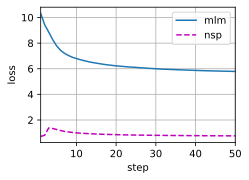

In [82]:
train_bert(train_iter, net, loss, len(vocab), devices, 50)

In [83]:
def get_bert_encoding(net, tokens_a, tokens_b=None):
    tokens, segments = get_tokens_and_segments(tokens_a, tokens_b)
    token_ids = torch.tensor(vocab[tokens], device=devices[0]).unsqueeze(0)
    segments = torch.tensor(segments, device=devices[0]).unsqueeze(0)
    valid_len = torch.tensor(len(tokens), device=devices[0]).unsqueeze(0)
    encoded_X, _, _ = net(token_ids, segments, valid_len)
    return encoded_X

In [84]:
tokens_a = ['a', 'crane', 'is', 'flying']
encoded_text = get_bert_encoding(net, tokens_a)
encoded_text_cls = encoded_text[:, 0, :]
encoded_text_crane = encoded_text[:, 2, :]
encoded_text.shape, encoded_text_cls.shape, encoded_text_crane[0][: 3]

(torch.Size([1, 6, 128]),
 torch.Size([1, 128]),
 tensor([ 0.0484, -0.8263,  0.0702], grad_fn=<SliceBackward0>))

In [85]:
tokens_a, tokens_b = ['a', 'crane', 'driver', 'came'], ['he', 'just', 'left']
encoded_pair = get_bert_encoding(net, tokens_a, tokens_b)
encoded_pair_cls = encoded_pair[:, 0, :]
encoded_pair_crane = encoded_pair[:, 2, :]
encoded_pair.shape, encoded_pair_cls.shape, encoded_pair_crane[0][: 3]

(torch.Size([1, 10, 128]),
 torch.Size([1, 128]),
 tensor([-0.5435,  0.1587,  0.1231], grad_fn=<SliceBackward0>))